Track loaded with 10 segments.
Starting AI optimization... (This may take a few minutes)
 The best solution found:                                                                           
 [1. 0. 0. 1. 1. 1. 0. 0. 2. 1.]

 Objective function:
 43.6927392423245


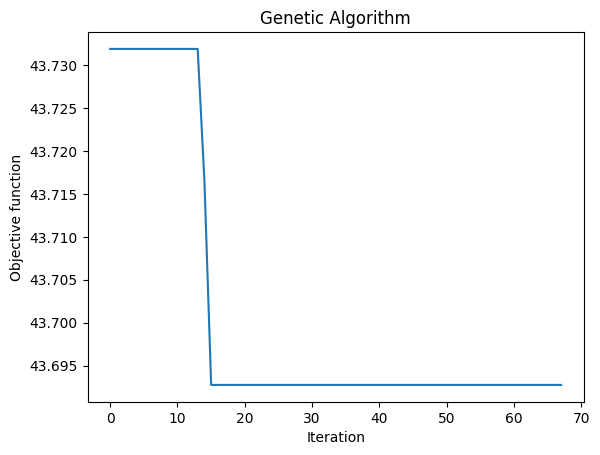


--- 🏁 AI Optimization Complete! ---
Fastest Lap Time Found: 43.693 seconds

Best Strategy:
['DEPLOY', 'COAST', 'COAST', 'DEPLOY', 'DEPLOY', 'DEPLOY', 'COAST', 'COAST', 'HARVEST', 'DEPLOY']

Generating lap visualization...
Saved visualization to 'optimal_lap.png'


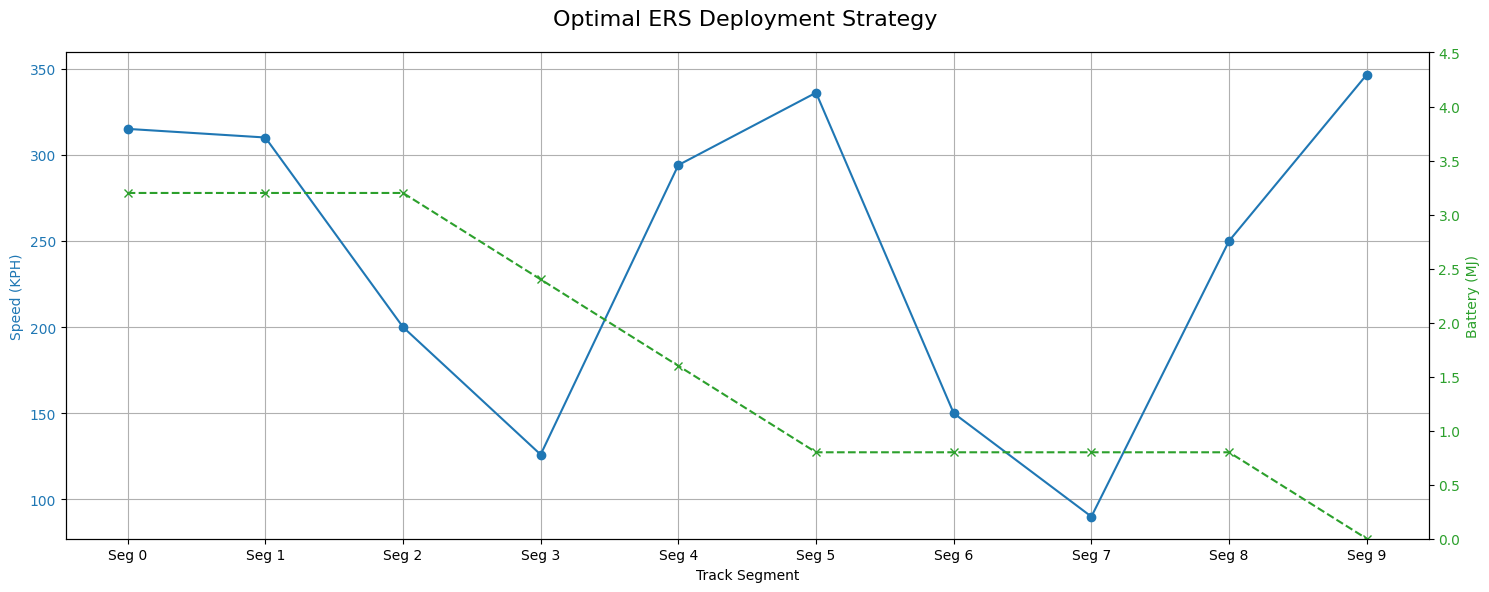

In [2]:
import pandas as pd
import numpy as np
from geneticalgorithm import geneticalgorithm as ga
import matplotlib.pyplot as plt

# --- 1. Define Your "World" Constants ---
MAX_BATTERY_MJ = 4.0       # Max capacity
MAX_DEPLOY_PER_LAP_MJ = 4.0  # Max you can USE in one lap
MAX_HARVEST_PER_LAP_MJ = 2.0 # Max you can GAIN in one lap

# ERS Actions (Our "Genes")
# 0 = COAST, 1 = DEPLOY, 2 = HARVEST
ACTION_COAST = 0
ACTION_DEPLOY = 1
ACTION_HARVEST = 2

# --- 2. Load the Track Data ---
try:
    track_df = pd.read_csv('track_data.csv')
    NUM_SEGMENTS = len(track_df)
    print(f"Track loaded with {NUM_SEGMENTS} segments.")
except FileNotFoundError:
    print("Error: 'track_data.csv' not found. Make sure it's in the same folder.")
    exit()



    # --- 3. Build the Simulator (The "Fitness Function") ---
# This is what the AI will try to optimize.
# It takes one argument: a list of decisions (the "chromosome")
# e.g., [1, 1, 0, 2, 0, 1, ...]
def calculate_lap_time(strategy):
    
    total_time_sec = 0
    current_battery_mj = MAX_BATTERY_MJ
    total_deployed_mj = 0
    total_harvested_mj = 0

    # These are our simplified "physics" assumptions
    DEPLOY_BOOST_PERCENT = 1.05  # 5% speed boost
    HARVEST_BRAKE_PERCENT = 0.85 # 15% speed penalty (from braking/harvesting)
    
    # Calculate energy cost/gain per segment (simplified)
    # This is a key assumption: 
    # Deploying for 1 segment costs X, harvesting gains Y
    
    # Simple model: Assume we can deploy on half the track
    ENERGY_COST_PER_DEPLOY_MJ = MAX_DEPLOY_PER_LAP_MJ / (NUM_SEGMENTS / 2) 
    
    # Simple model: Assume we can harvest on 1/4 of the track
    ENERGY_GAIN_PER_HARVEST_MJ = MAX_HARVEST_PER_LAP_MJ / (NUM_SEGMENTS / 4) 

    for i in range(NUM_SEGMENTS):
        segment = track_df.iloc[i]
        # strategy[i] will be 0, 1, or 2
        decision = strategy[i]
        
        speed_kph = segment['baseline_speed_kph']
        
        # --- Apply AI Decision ---
        if decision == ACTION_DEPLOY:
            # Can we deploy?
            if current_battery_mj > ENERGY_COST_PER_DEPLOY_MJ and total_deployed_mj < MAX_DEPLOY_PER_LAP_MJ:
                speed_kph *= DEPLOY_BOOST_PERCENT
                current_battery_mj -= ENERGY_COST_PER_DEPLOY_MJ
                total_deployed_mj += ENERGY_COST_PER_DEPLOY_MJ
            # else, we wanted to deploy but couldn't, so we just coast
            
        elif decision == ACTION_HARVEST:
            # Can we harvest? (Must be a braking zone and not full battery)
            if segment['is_braking_zone'] == 1 and current_battery_mj < MAX_BATTERY_MJ and total_harvested_mj < MAX_HARVEST_PER_LAP_MJ:
                speed_kph *= HARVEST_BRAKE_PERCENT
                current_battery_mj += ENERGY_GAIN_PER_HARVEST_MJ
                total_harvested_mj += ENERGY_GAIN_PER_HARVEST_MJ
            # else, we wanted to harvest but couldn't, so we just coast
        
        # --- Calculate Time for this Segment ---
        if speed_kph == 0: # Avoid division by zero
            return 99999 # Invalid strategy, give a terrible time
            
        speed_mps = speed_kph / 3.6 # Convert kph to meters/sec
        time_for_segment_sec = segment['length_m'] / speed_mps
        total_time_sec += time_for_segment_sec

    # --- Penalty for invalid laps ---
    # If the AI used too much energy, give it a HUGE time penalty
    # This teaches the AI to avoid this.
    if total_deployed_mj > MAX_DEPLOY_PER_LAP_MJ or total_harvested_mj > MAX_HARVEST_PER_LAP_MJ:
        return 99999 # Invalid lap, very bad score

    return total_time_sec


# --- 4. Setup and Run the AI ---
print("Starting AI optimization... (This may take a few minutes)")

# We need to tell the AI what its "genes" can be
# Dimension: How many genes (decisions)? One for each track segment.
# Variable type: 'int' (0, 1, or 2)
# Boundaries: The min and max value for each gene (min=0, max=2)
var_boundaries = np.array([[0, 2]] * NUM_SEGMENTS)

# AI parameters (you can tweak these)
algorithm_param = {
    'max_num_iteration': 500,  # How many "generations" to run
    'population_size': 100,      # How many "strategies" to test in each generation
    'mutation_probability': 0.1, # How often to randomly change a decision
    'elit_ratio': 0.01,  
    'parents_portion': 0.8,        # Keep the best 1% of strategies for the next generation
    'crossover_probability': 0.5,
    'crossover_type': 'uniform',
    'max_iteration_without_improv': 50 # Stop if the time doesn't improve for 50 generations
}

# Create the AI model
model = ga(
    function=calculate_lap_time,    # Tell the AI to use our simulator as its "fitness"
    dimension=NUM_SEGMENTS,
    variable_type='int',
    variable_boundaries=var_boundaries,
    algorithm_parameters=algorithm_param
)

# Run the AI! This is where the magic happens.
model.run()

# --- 5. Get and Display the Results ---
best_strategy = model.best_variable
best_lap_time = model.best_function

print("\n--- 🏁 AI Optimization Complete! ---")
print(f"Fastest Lap Time Found: {best_lap_time:.3f} seconds")

# Decode the strategy from numbers (0,1,2) to words
strategy_decoded = []
for decision in best_strategy:
    if decision == ACTION_DEPLOY:
        strategy_decoded.append("DEPLOY")
    elif decision == ACTION_HARVEST:
        strategy_decoded.append("HARVEST")
    else:
        strategy_decoded.append("COAST")

print("\nBest Strategy:")
# This will print the winning list of decisions
print(strategy_decoded)
# --- 6. Visualize the Winning Lap ---
# We must re-run the simulation with the best strategy to log the data
print("\nGenerating lap visualization...")

# Lists to store telemetry
l_speed_kph = []
l_battery_mj = []

# --- Re-run the simulator using the best strategy ---
current_battery_mj = MAX_BATTERY_MJ
total_deployed_mj = 0
total_harvested_mj = 0

# (Need to redefine these constants inside this section for this re-run)
DEPLOY_BOOST_PERCENT = 1.05
HARVEST_BRAKE_PERCENT = 0.85
ENERGY_COST_PER_DEPLOY_MJ = MAX_DEPLOY_PER_LAP_MJ / (NUM_SEGMENTS / 2)
ENERGY_GAIN_PER_HARVEST_MJ = MAX_HARVEST_PER_LAP_MJ / (NUM_SEGMENTS / 4)

for i in range(NUM_SEGMENTS):
    segment = track_df.iloc[i]
    decision = best_strategy[i]
    
    speed_kph = segment['baseline_speed_kph']
    
    if decision == ACTION_DEPLOY:
        if current_battery_mj > ENERGY_COST_PER_DEPLOY_MJ and total_deployed_mj < MAX_DEPLOY_PER_LAP_MJ:
            speed_kph *= DEPLOY_BOOST_PERCENT
            current_battery_mj -= ENERGY_COST_PER_DEPLOY_MJ
            total_deployed_mj += ENERGY_COST_PER_DEPLOY_MJ
            
    elif decision == ACTION_HARVEST:
        if segment['is_braking_zone'] == 1 and current_battery_mj < MAX_BATTERY_MJ and total_harvested_mj < MAX_HARVEST_PER_LAP_MJ:
            speed_kph *= HARVEST_BRAKE_PERCENT
            current_battery_mj += ENERGY_GAIN_PER_HARVEST_MJ
            total_harvested_mj += ENERGY_GAIN_PER_HARVEST_MJ

    # Log the data for this segment
    l_speed_kph.append(speed_kph)
    l_battery_mj.append(current_battery_mj)

# --- Create the Plot ---
segment_labels = [f"Seg {i}" for i in range(NUM_SEGMENTS)]

fig, ax1 = plt.subplots(figsize=(15, 6)) # Make the graph wider

# Plot 1: Speed (Left Y-axis)
color = 'tab:blue'
ax1.set_xlabel('Track Segment')
ax1.set_ylabel('Speed (KPH)', color=color)
ax1.plot(segment_labels, l_speed_kph, color=color, marker='o', label='Speed')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

# Plot 2: Battery (Right Y-axis)
ax2 = ax1.twinx() # Create a second y-axis that shares the same x-axis
color = 'tab:green'
ax2.set_ylabel('Battery (MJ)', color=color)
ax2.plot(segment_labels, l_battery_mj, color=color, linestyle='--', marker='x', label='Battery')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, MAX_BATTERY_MJ + 0.5) # Set fixed battery scale

fig.suptitle('Optimal ERS Deployment Strategy', fontsize=16)
fig.tight_layout() # Adjust plot to prevent labels from overlapping

# Save the plot to a file and show it
plt.savefig('optimal_lap.png')
print("Saved visualization to 'optimal_lap.png'")
plt.show()